In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()



In [2]:
#import
station_location = pd.read_csv('Nice_Ride_2017_Station_Locations.csv', low_memory=False)
trip_history = pd.read_csv('Nice_ride_trip_history_2017_season.csv', low_memory=False)

#test
station_location.sample(n=10)

,ID,Number,Name,Latitude,Longitude,Total docks
189,190,30192,Cooke Hall,44.976303,-93.230029,15
52,53,30053,2nd Ave N & N 6th Street,44.980536,-93.275626,23
106,107,30109,Como Ave SE & 29th Ave SE,44.987934,-93.212892,19
47,48,30048,Dupont Ave & 22nd Street,44.961460,-93.293030,15
157,158,30160,Dupont Ave S & W 29th Street,44.949699,-93.293129,15
116,117,30119,Union Depot,44.948399,-93.086584,23
48,49,30049,Nicollet Ave & W 37th Street,44.935318,-93.278078,15
42,43,30043,Lake Street & Humboldt,44.948650,-93.300770,19
19,20,30019,Social Sciences,44.970639,-93.243552,27
32,33,30032,4th Street & 17th Ave SE,44.979130,-93.231890,15


In [3]:
#test

trip_history.sample(n=10)

,ID,Start Date,Start Time,Start station,Start station number,End Date,End Time,End station,End station number,Account type,Total duration (Seconds),Duration (Min)
176008,176009,8/5/2017,13:45,W 36th Street & W Calhoun Parkway,30166,8/5/2017,14:20,Lake Street & Knox Ave S,30158,Casual,858,14.300000
404569,404570,5/9/2017,22:45,Delaware Street SE & 26th Ave SE,30189,5/9/2017,12:19,Delaware Street SE & 26th Ave SE,30189,Casual,6522,108.700000
410578,410579,5/6/2017,7:45,11th Street & Hennepin,30004,5/6/2017,16:36,Hennepin & Laurel Ave,30010,Member,236,3.933333
61924,61925,9/23/2017,1:45,Oak Street Ramp,30034,9/23/2017,10:43,Wilder Street & Marshall Ave,30083,Casual,847,14.116667
355486,355487,6/2/2017,19:45,Washington Ave N & Cedar Lake Trail,30176,6/2/2017,20:19,North 2nd Street & 4th Ave N,30011,Casual,5195,86.583333
232359,232360,7/16/2017,12:45,Lake Nokomis,30156,7/16/2017,12:06,Minnehaha Park,30149,Casual,779,12.983333
182051,182052,8/2/2017,8:45,28th Street & Nicollet Ave. S,30064,8/2/2017,20:07,W 50th Street & W Minnehaha Pkwy,30203,Member,2048,34.133333
238476,238477,7/14/2017,9:45,Wirth Beach,30066,7/14/2017,14:18,Walker Art Center,30016,Member,1955,32.583333
333830,333831,6/11/2017,11:45,6th Ave SE & University Ave,30088,6/11/2017,0:57,15th Ave SE & Como Ave SE,30110,Casual,932,15.533333
187747,187748,7/31/2017,16:45,YWCA Downtown,30006,7/31/2017,20:17,11th Street & Marquette,30040,Casual,3319,55.316667


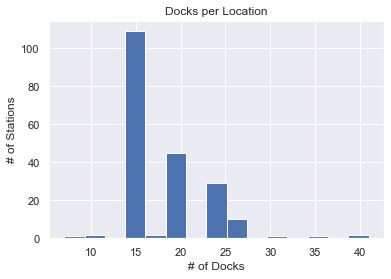

In [4]:
# Num Docks per Location
plt.figure()
plt.hist(station_location['Total docks'], 
         bins=15)
plt.ylabel('# of Stations')
plt.xlabel('# of Docks')
plt.title('Docks per Location')
plt.show()

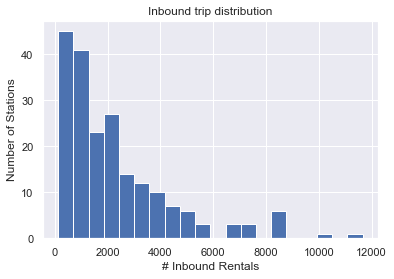

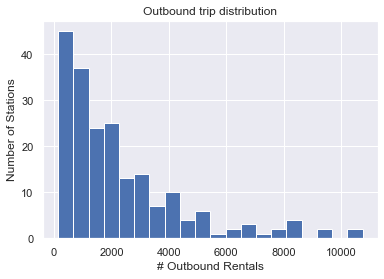

Number of outbound trips: 460718
Number of inbound trips: 460718


In [5]:
demand_df = pd.DataFrame({
    'Outbound trips': trip_history.groupby('Start station').size(),
    'Inbound trips': trip_history.groupby('End station').size()
})
demand_df['Name'] = demand_df.index
sdf = station_location.merge(demand_df, on='Name')

#inbound graph
plt.figure()
plt.hist(sdf['Inbound trips'], bins=20)
plt.ylabel('Number of Stations')
plt.xlabel('# Inbound Rentals')
plt.title('Inbound trip distribution')
plt.show()

#outbound graph
plt.figure()
plt.hist(sdf['Outbound trips'], bins=20)
plt.ylabel('Number of Stations')
plt.xlabel('# Outbound Rentals')
plt.title('Outbound trip distribution')
plt.show()

#confirm equal inbound vs outbound
print('Number of outbound trips: %d'%(sdf['Outbound trips'].sum()))
print('Number of inbound trips: %d'%(sdf['Inbound trips'].sum()))

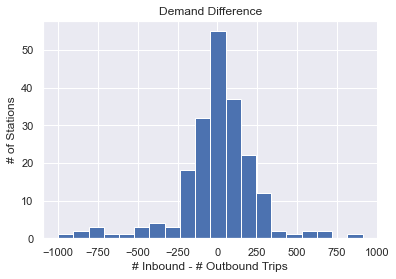

In [6]:
#inbound vs outbound trips
sdf['demand_diff'] = sdf['Inbound trips']-sdf['Outbound trips']

plt.figure()
plt.hist(sdf['demand_diff'], bins=20)
plt.ylabel('# of Stations')
plt.xlabel('# Inbound - # Outbound Trips')
plt.title('Demand Difference')
plt.show()

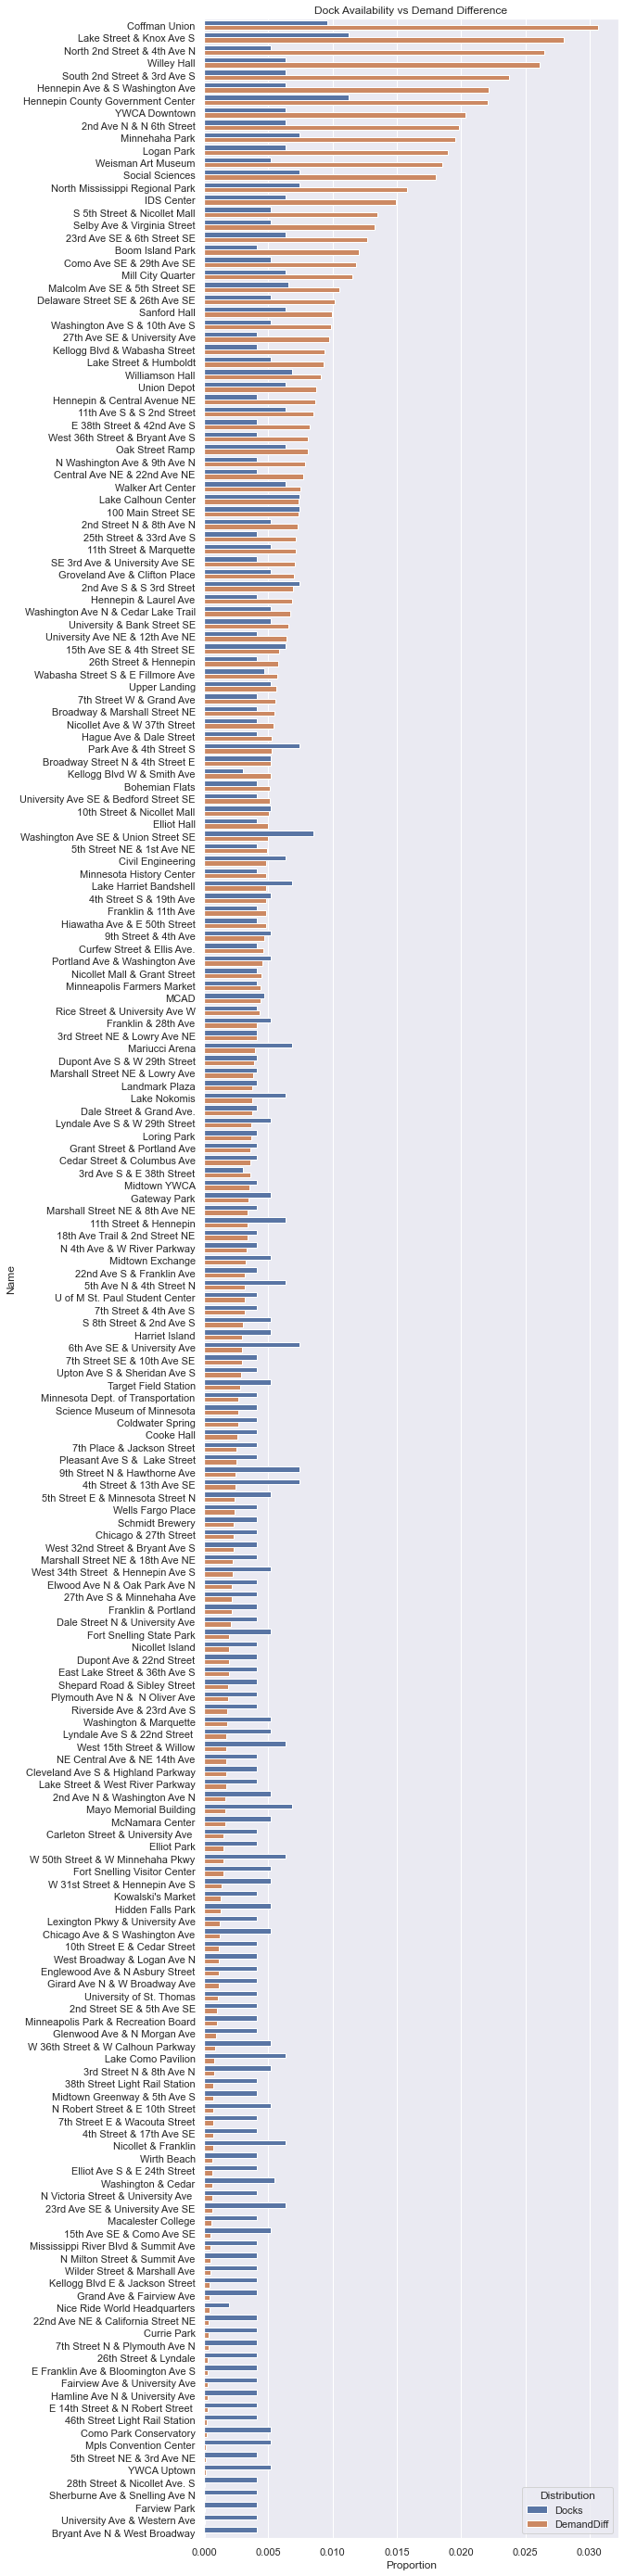

In [7]:
#find abslt value
sdf['abslt_diff'] = sdf['demand_diff'].abs()

#dock availability vs demand difference
sdf['Docks'] = sdf['Total docks']/sdf['Total docks'].sum()
sdf['DemandDiff'] = sdf['abslt_diff']/sdf['abslt_diff'].sum()

#?? make seaborn work!
seaborn_data_cleaned = (
    sdf[['Name', 'Docks', 'DemandDiff']]
       .set_index('Name')
       .stack()
       .reset_index()
       .rename(columns={'level_1':'Distribution', 0:'Proportion'})
)

#graph
plt.figure(figsize=(8, 50))
station_list = (
    sdf
    .sort_values('DemandDiff', ascending=False)['Name']
    .tolist()
)

sns.barplot(y='Name', x='Proportion', hue='Distribution', 
            data=seaborn_data_cleaned, order=station_list)
plt.title('Dock Availability vs Demand Difference')
plt.show()


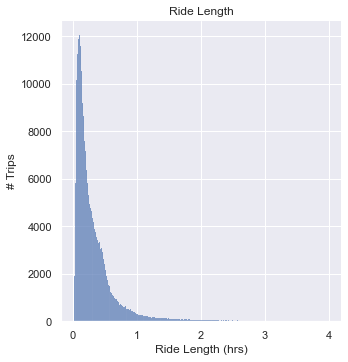

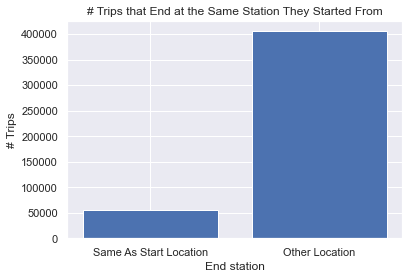

In [8]:
trips = (
    trip_history.groupby(['Start station', 'End station'])['Start Date']
    .count().to_frame().reset_index()
    .rename(columns={"Start Date": "Trips"})
    .pivot(index='Start station', columns='End station')
    .fillna(value=0)
)

#Ride Length
sns.displot(trip_history.loc[trip_history['Total duration (Seconds)']<(4*60*60),
                       'Total duration (Seconds)']/3600)
plt.xlabel('Ride Length (hrs)')
plt.ylabel('# Trips')
plt.title('Ride Length')
plt.show()

#Return Location

plt.bar([0, 1], 
        [np.trace(trips.values), 
         trips.values.sum()-np.trace(trips.values)],
        tick_label=['Same As Start Location', 'Other Location'])
plt.xlabel('End station')
plt.ylabel('# Trips')
plt.title('# Trips that End at the Same Station They Started From')
plt.show()


C:\Users\mango\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


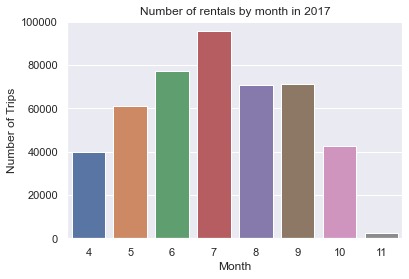

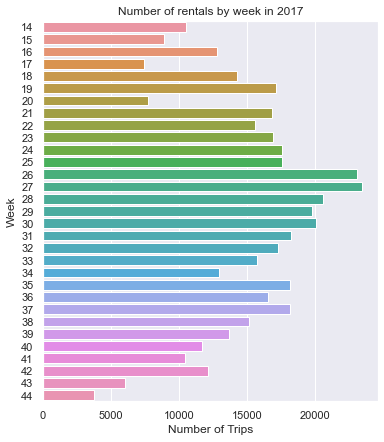

C:\Users\mango\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


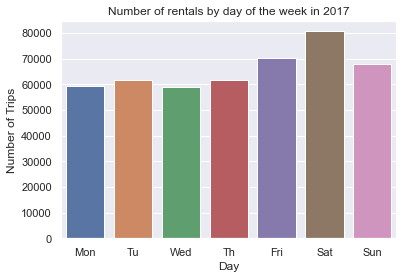

In [14]:
#change date from object to date datatype
for col in ['Start Date', 'End Date']:
    trip_history[col] = pd.to_datetime(trip_history[col],
                                format='%m/%d/%Y')
    
# num rentals per month    
plt.figure()
sns.countplot(trip_history['Start Date'].dt.month)
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.title('Number of rentals by month in 2017')
plt.show()

# num rentals per week 
plt.figure(figsize=(6, 7))
sns.countplot(y=trip_history['Start Date'].dt.isocalendar().week)
plt.ylabel('Week')
plt.xlabel('Number of Trips')
plt.title('Number of rentals by week in 2017')
plt.show()

#num rentals per day of the week
plt.figure()
sns.countplot(trip_history['Start Date'].dt.weekday)
plt.xlabel('Day')
plt.ylabel('Number of Trips')
plt.title('Number of rentals by day of the week in 2017')
plt.xticks(np.arange(7),
           ['Mon', 'Tu', 'Wed', 'Th', 'Fri', 'Sat', 'Sun'])
plt.show()

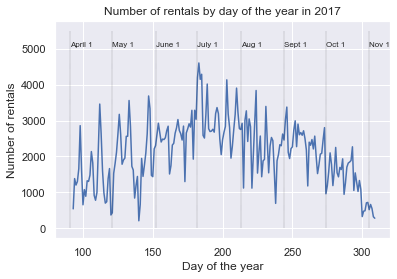

In [15]:
gt = trip_history.groupby(trip_history['Start Date'].dt.dayofyear)['Start Date']
gt.count().plot()
plt.xlabel('Day of the year')
plt.ylabel('Number of rentals')
plt.title('Number of rentals by day of the year in 2017')

month_first = [("April 1", 91),
            ("May 1", 121),
            ("June 1", 152),
            ("July 1", 182),
            ("Aug 1", 213),
            ("Sept 1", 244),
            ("Oct 1", 274),
            ("Nov 1", 305)]
for name, day in month_first:
    plt.plot([day,day], [0,5500], 
             'k--', linewidth=0.2)
    plt.text(day, 5200, name, fontsize=8, 
             va='top')

plt.show()


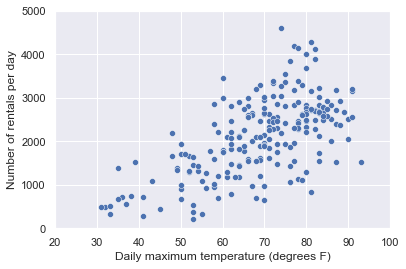

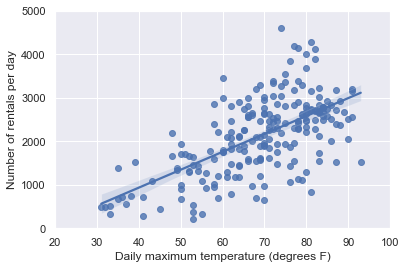

In [16]:
weather = pd.read_csv('WeatherDailyMinneapolis2017.csv', low_memory=False)
for col in ['DATE']:
    weather[col] = pd.to_datetime(weather[col],
                                format='%m/%d/%y')


trips_per_day = (
    trip_history
    .groupby(trip_history['Start Date'].dt.dayofyear)
    .size()
    .rename('trips')
)

# Add the trips to weather table
weather['dayofyear'] = weather.DATE.dt.dayofyear
weather = (
    weather
    .set_index('dayofyear')
    .join(trips_per_day)
)

#max temp vs #trips per day
sns.scatterplot(x='TMAX', y='trips', data=weather)
plt.xlabel('Daily maximum temperature (degrees F)')
plt.ylabel('Number of rentals per day')
plt.xlim([20, 100])
plt.ylim([0, 5000])
plt.show()

#graph with regression
sns.regplot(x='TMAX', y='trips', data=weather)
plt.xlabel('Daily maximum temperature (degrees F)')
plt.ylabel('Number of rentals per day')
plt.xlim([20, 100])
plt.ylim([0, 5000])
plt.show()
